# # Creation of final datasheet:

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import scipy.stats as stats
# !pip install pingouin
import pingouin as pg
from statsmodels.stats.weightstats import ttest_ind

In [66]:
df_main1 = pd.DataFrame(columns = ['name' ,'activity' ,'weight', 'duration','start_time' ,'change_in_load', 'variance',  'maximum', 'median', 'skewness', 'kurtosis', '0.9_quantile', 'acceleration', 'jerk', 'velocity', 'energy', 'power', 'momentum'])
df_main1

,name,activity,weight,duration,start_time,change_in_load,variance,maximum,median,skewness,kurtosis,0.9_quantile,acceleration,jerk,velocity,energy,power,momentum


In [67]:
def value_insertion(loc_csv):
    df=pd.read_csv(loc_csv)
#     print(loc_csv) # Print this if you want to track which folder is running while running the code
    df_main1.loc[len(df_main1.index)] = [df['name'][0], df['activity'][0], df['weight'][0], df['timestamp'][len(df)-1], df['start_time'][0], df['diff_load_sum'].mean(), df['diff_load_sum'].var(), df['diff_load_sum'].max(), df['diff_load_sum'].median(), df['diff_load_sum'].skew(), df['diff_load_sum'].kurtosis(), df['diff_load_sum'].quantile(0.9), df['acc'].mean(), df['jerk'].mean(), df['velo'].mean(), df['enr'].mean(), df['power'].mean(), df['mom'].mean()]
    return df_main1

In [68]:
rootdir = "D:/Ajit/pip/sample_labeled9"
folder_list = []
for subdir, dirs, files in os.walk(rootdir):
    folder_list.append(subdir)
del folder_list[0]

In [69]:
i=0
for folder in folder_list:
    path=folder
    for filename in os.listdir(path):
        x=path+'/'+filename
#         print(i) # Print this if you want to track which folder is running while running the code
        value_insertion(x)
        i+=1

In [6]:
# Taking backup of loaded dataset as 'df_main1'
df_main=df_main1.copy()

# # Data Cleaning:

In [7]:
df_main.head(3)

,name,activity,weight,duration,start_time,change_in_load,variance,maximum,median,skewness,kurtosis,0.9_quantile,acceleration,jerk,velocity,energy,power,momentum
0,Ryan,defecation,6933,163.97500,2020-08-06 10:08:05-05:00,1.114670,2.425972,14.11659,0.43164,2.088879,5.125106,3.23730,0.160777,2.623752,18.629980,1422.404601,14.699895,129.161654
1,Ryan,defecation,6451,204.77494,2020-09-08 04:32:58-05:00,0.996088,2.262248,19.98297,0.32373,2.502551,9.150935,3.06072,0.154408,2.854197,20.030623,1626.238512,15.753942,129.217548
2,Ryan,defecation,7240,59.97500,2020-07-16 23:03:12-05:00,0.292591,0.218968,4.16925,0.05886,2.892435,11.742110,0.87309,0.040413,0.638543,1.792097,13.463229,0.355113,12.974780


In [8]:
df_main.shape

(13075, 18)

### 1. Null values

In [9]:
df_main.isnull().sum()

name              246
activity            3
weight              0
duration            0
start_time          0
change_in_load      0
variance            0
maximum             0
median              0
skewness            0
kurtosis            0
0.9_quantile        0
acceleration        0
jerk               10
velocity            0
energy              0
power               0
momentum            0
dtype: int64

In [10]:
# Filling missing values of cat name with 'unknown' and dropping other null values
df_main['name'].fillna('unknown',inplace=True)
df_main.dropna(inplace=True)
df_main.shape

(13062, 18)

### 2. Outlier Analysis using Boxplot

In [11]:
df_main.groupby(['activity'])['activity'].count()

activity
defecation         2316
non_elimination    4137
urination          6609
Name: activity, dtype: int64

<AxesSubplot: xlabel='activity', ylabel='momentum'>

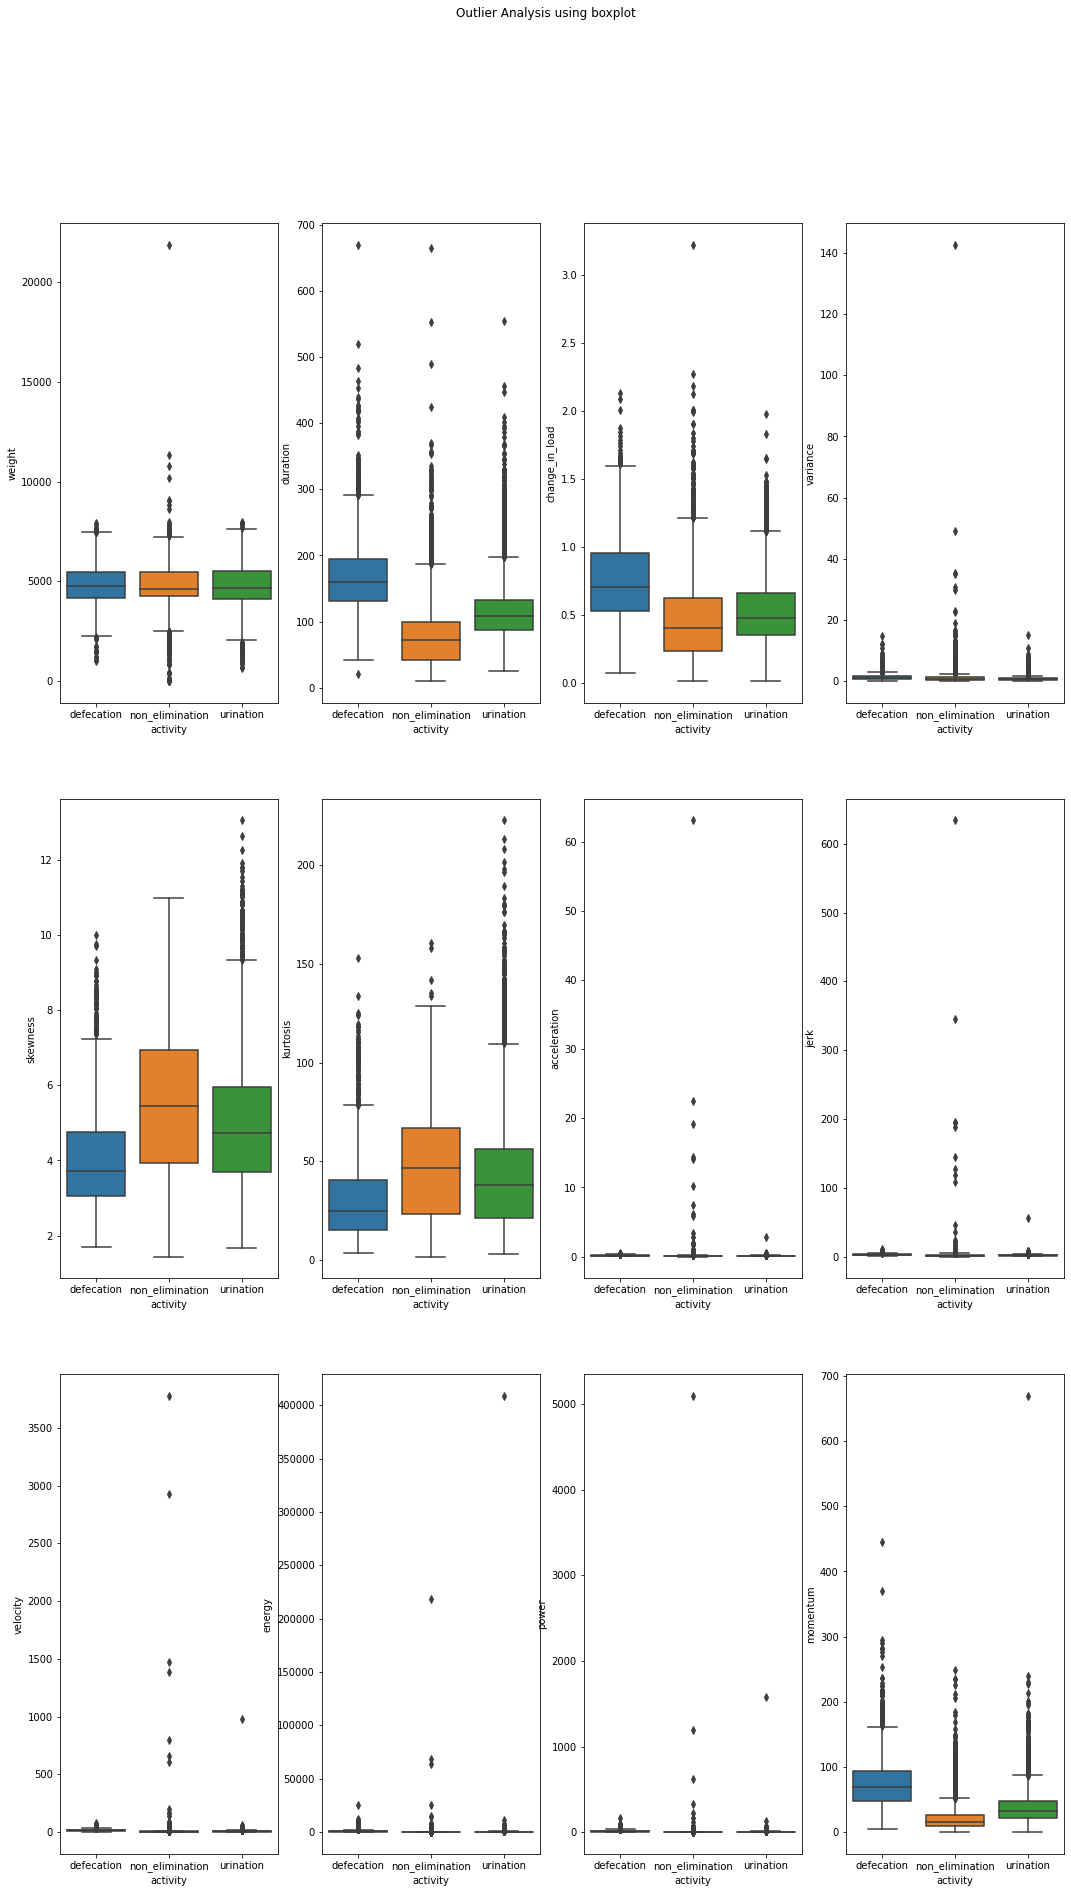

In [12]:
fig, axes = plt.subplots(3, 4, figsize=(18, 30))

fig.suptitle('Outlier Analysis using boxplot')

sns.boxplot(ax=axes[0, 0], data=df_main, x='activity', y='weight')
sns.boxplot(ax=axes[0, 1], data=df_main, x='activity', y='duration')
sns.boxplot(ax=axes[0, 2], data=df_main, x='activity', y='change_in_load')
sns.boxplot(ax=axes[0, 3], data=df_main, x='activity', y='variance')
sns.boxplot(ax=axes[1, 0], data=df_main, x='activity', y='skewness')
sns.boxplot(ax=axes[1, 1], data=df_main, x='activity', y='kurtosis')
sns.boxplot(ax=axes[1, 2], data=df_main, x='activity', y='acceleration')
sns.boxplot(ax=axes[1, 3], data=df_main, x='activity', y='jerk')
sns.boxplot(ax=axes[2, 0], data=df_main, x='activity', y='velocity')
sns.boxplot(ax=axes[2, 1], data=df_main, x='activity', y='energy')
sns.boxplot(ax=axes[2, 2], data=df_main, x='activity', y='power')
sns.boxplot(ax=axes[2, 3], data=df_main, x='activity', y='momentum')

### 3. Outliers removal

#### i. Weight Outlier = weight < 1kg (27 Rows) or weight > 8kg (8 Rows)

In [13]:
df_main[df_main['weight']<1000]['weight'].count()

27

In [14]:
df_main[df_main['weight']>8000]['weight'].count()

8

In [15]:
df_main=df_main[(df_main['weight']>1000) & (df_main['weight']<8000)]
df_main.shape

(13027, 18)

#### ii. Activity Duration (15 Rows)

In [16]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['duration']>450))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['duration']>360))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['duration']>400))])))

Defecation : 5
Non elimination : 6
Urination : 4


In [17]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['duration']>450))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['duration']>360))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['duration']>400))]
df_main.shape

(13012, 18)

#### iii. 'Change in Load' (20 Rows)

In [18]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['change_in_load']>1.8))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['change_in_load']>1.8))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['change_in_load']>1.5))])))

Defecation : 6
Non elimination : 10
Urination : 4


In [19]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['change_in_load']>1.8))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['change_in_load']>1.8))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['change_in_load']>1.5))]
df_main.shape

(12992, 18)

#### iv. Variance (17 Rows)

In [20]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['variance']>8))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['variance']>15))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['variance']>7))])))

Defecation : 5
Non elimination : 6
Urination : 6


In [21]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['variance']>8))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['variance']>15))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['variance']>7))]
df_main.shape

(12975, 18)

#### v. Skewness (4 Rows)

In [22]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['skewness']>10))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['skewness']>11))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['skewness']>12))])))

Defecation : 0
Non elimination : 1
Urination : 3


In [23]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['skewness']>10))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['skewness']>11))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['skewness']>12))]
df_main.shape

(12971, 18)

#### vi. Kurtosis (14 Rows)

In [24]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['kurtosis']>125))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['kurtosis']>125))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['kurtosis']>180))])))

Defecation : 3
Non elimination : 5
Urination : 6


In [25]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['kurtosis']>125))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['kurtosis']>125))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['kurtosis']>125))]
df_main.shape

(12862, 18)

#### vii. 'Acceleration' (20 Rows)

In [26]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['acceleration']>0.41))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['acceleration']>0.34))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['acceleration']>0.34))])))

Defecation : 3
Non elimination : 11
Urination : 6


In [27]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['acceleration']>0.41))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['acceleration']>0.34))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['acceleration']>0.34))]
df_main.shape

(12842, 18)

#### viii. 'Jerk' (22 Rows)

In [28]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['jerk']>7))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['jerk']>6))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['jerk']>5.8))])))

Defecation : 6
Non elimination : 8
Urination : 8


In [29]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['jerk']>7))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['jerk']>6))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['jerk']>5.8))]
df_main.shape

(12820, 18)

#### ix. 'Velocity' (23 Rows)

In [30]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['velocity']>45))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['velocity']>32))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['velocity']>34))])))

Defecation : 8
Non elimination : 6
Urination : 9


In [31]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['velocity']>45))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['velocity']>32))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['velocity']>34))]
df_main.shape

(12797, 18)

#### x. 'Energy' (34 Rows)

In [32]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['energy']>5000))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['energy']>2100))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['energy']>3000))])))

Defecation : 10
Non elimination : 11
Urination : 12


In [33]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['energy']>5000))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['energy']>2100))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['energy']>3000))]
df_main.shape

(12764, 18)

#### xi. 'Power' (34 Rows)

In [34]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['power']>47))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['power']>20))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['power']>27))])))

Defecation : 10
Non elimination : 11
Urination : 13


In [35]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['power']>47))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['power']>20))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['power']>27))]
df_main.shape

(12730, 18)

#### xii. 'Momentum' (21 Rows)

In [36]:
print("Defecation : "+str(len(df_main[((df_main['activity']=='defecation') & (df_main['momentum']>195))])))
print("Non elimination : "+str(len(df_main[((df_main['activity']=='non_elimination') & (df_main['momentum']>125))])))
print("Urination : "+str(len(df_main[((df_main['activity']=='urination') & (df_main['momentum']>135))])))

Defecation : 7
Non elimination : 5
Urination : 9


In [37]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['momentum']>195))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['momentum']>125))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['momentum']>135))]
df_main.shape

(12709, 18)

#### All boxplot after outlier removal

In [38]:
df_main.describe()

,weight,duration,change_in_load,variance,maximum,median,skewness,kurtosis,0.9_quantile,acceleration,jerk,velocity,energy,power,momentum
count,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000,12709.000000
mean,4816.829727,111.296986,0.544684,0.907847,11.745516,0.223101,4.905714,40.581550,1.356294,0.113680,1.934801,7.998461,298.683255,4.514172,38.429377
std,948.075574,54.885906,0.295428,0.895666,5.027957,0.259785,1.659897,24.341059,0.666162,0.057951,1.016838,5.739959,461.881218,5.677530,28.477790
min,1015.000000,10.398010,0.012697,0.000319,0.176580,0.009810,1.442729,1.633635,0.019620,0.004519,0.071433,0.151455,0.046659,0.002055,0.437790
25%,4184.000000,73.877687,0.332959,0.411699,8.328690,0.058860,3.551608,19.733390,0.922140,0.070855,1.202695,3.737115,39.549679,1.003797,17.445310
50%,4651.000000,105.574971,0.486641,0.681984,10.987200,0.127530,4.678931,36.623911,1.324350,0.102531,1.755364,6.472245,121.030640,2.339969,30.369961
75%,5498.000000,139.974946,0.689178,1.094217,14.195070,0.284490,6.073563,57.409129,1.746180,0.146537,2.471606,10.681418,347.091491,5.353492,52.002490
max,7968.000000,436.774948,1.759701,14.785958,51.734408,1.265490,10.372778,124.931431,5.052150,0.383762,6.936384,39.057109,4931.184152,46.628187,193.292799


In [39]:
df_main2 = df_main[['weight', 'duration', 'change_in_load', 'acceleration', 'jerk','velocity', 'energy', 'power', 'momentum']]
df_main2.columns

Index(['weight', 'duration', 'change_in_load', 'acceleration', 'jerk',
       'velocity', 'energy', 'power', 'momentum'],
      dtype='object')

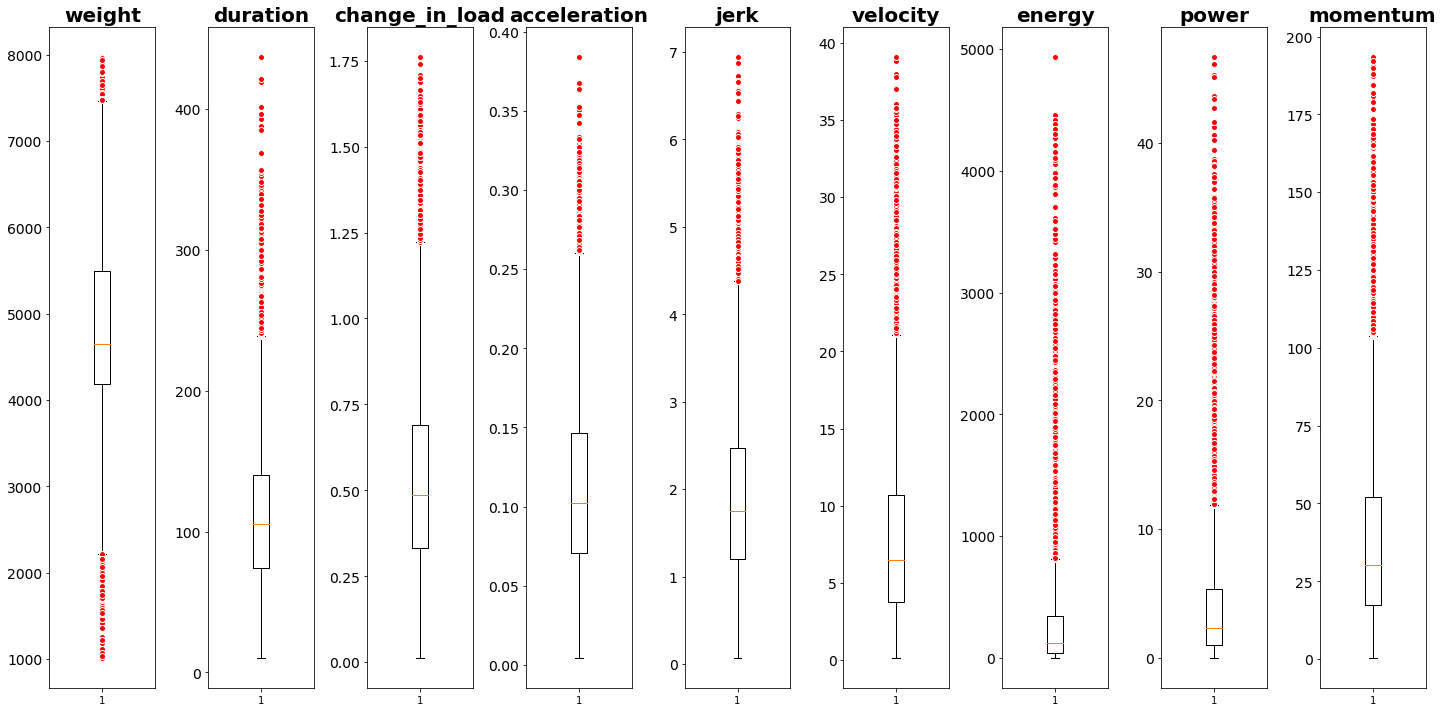

In [40]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(df_main2.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_main2.iloc[:,i], flierprops=red_circle)
    ax.set_title(df_main2.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

In [41]:
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['energy']>4500))]

# EDA of Final datasheet:

### 1. Number of rows with different activities

#### i. Defecation, Non_elimination and Urination

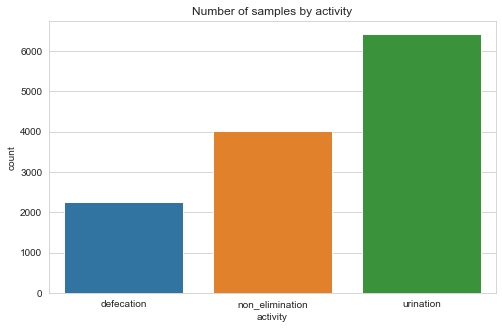

In [42]:
sns.set_style('whitegrid')
plt.figure(figsize = (8, 5))
sns.countplot(x = 'activity', data = df_main)
plt.title('Number of samples by activity')
plt.show()

### Converting urination and defecation to elimination

In [43]:
elemination_condition = ['urination', 'defecation']
df_main['activity1']=df_main['activity'].apply(lambda x: x if x not in elemination_condition else 'elemination')

#### ii. Number of rows with 'Elimination' and 'Non elimination'

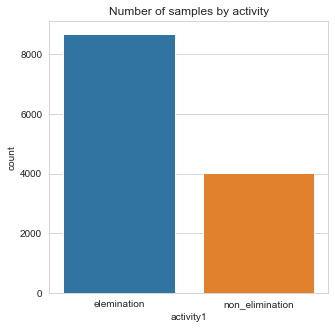

In [44]:
sns.set_style('whitegrid')
plt.figure(figsize = (5, 5))
sns.countplot(x = 'activity1', data = df_main)
plt.title('Number of samples by activity')
plt.show()

#### iii. Number of rows with 'Urination' and 'Defecation'

In [45]:
df_elimination = df_main[df_main['activity'] != 'non_elimination']

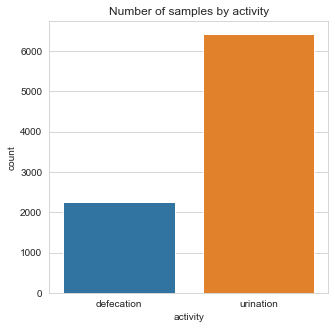

In [46]:
sns.set_style('whitegrid')
plt.figure(figsize = (5, 5))
sns.countplot(x = 'activity', data = df_elimination)
plt.title('Number of samples by activity')
plt.show()

### Distribution plot of "change in load"

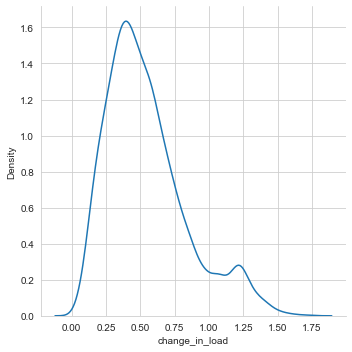

In [47]:
sns.displot(x=df_main['change_in_load'], kind="kde")

### Analysis of Individual cat

#### i. Activity Duration with weight of the cat

In [48]:
df_Gremlin=df_main[df_main['name']=='Gremlin']
df_Gremlin=df_Gremlin[df_Gremlin['weight']>4500]

<AxesSubplot: xlabel='weight', ylabel='duration'>

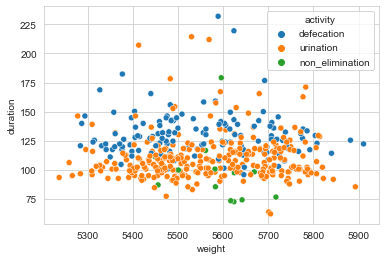

In [49]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_Gremlin,  x='weight', y='duration', hue='activity')

#### i.e. There are not much variation of activity duration with weight of cat

#### ii. Change in load vs weight of cat

In [50]:
df_Gremlin=df_Gremlin[df_Gremlin['change_in_load']>0.75]

<AxesSubplot: xlabel='weight', ylabel='change_in_load'>

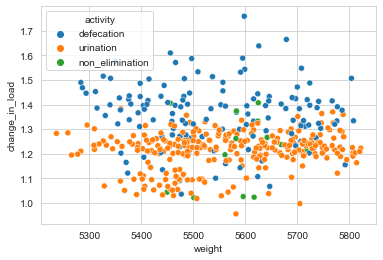

In [51]:

plt.figure(figsize=(6,4))
sns.scatterplot(data=df_Gremlin,  x='weight', y='change_in_load', hue='activity', size=None, style=None, sizes=None)

# Question Answers

### Q. How do the statistical measures (e.g., mean load value, variance etc.) of load sensor data differ for each activity?

In [70]:
df_sum_stat=pd.DataFrame()

In [53]:
df_sum_stat['change_in_load']=df_main.groupby(['activity'])['change_in_load'].mean()
df_sum_stat['variance']=df_main.groupby(['activity'])['variance'].mean()
df_sum_stat['median']=df_main.groupby(['activity'])['median'].mean()
df_sum_stat['skewness']=df_main.groupby(['activity'])['skewness'].mean()
df_sum_stat['kurtosis']=df_main.groupby(['activity'])['kurtosis'].mean()
df_sum_stat['0.9quantile']=df_main.groupby(['activity'])['0.9_quantile'].mean()

#### 1. Table of statistical measures

In [54]:
df_sum_stat.reset_index(inplace=True)
df_sum_stat

,activity,change_in_load,variance,median,skewness,kurtosis,0.9quantile
0,defecation,0.754053,1.167052,0.363323,4.033054,30.251160,1.856901
1,non_elimination,0.452097,0.970231,0.159440,5.425495,45.897016,1.132912
2,urination,0.529222,0.777174,0.213797,4.885582,40.867168,1.320612


#### 2. Plot of statistical measures

<AxesSubplot: xlabel='activity', ylabel='0.9quantile'>

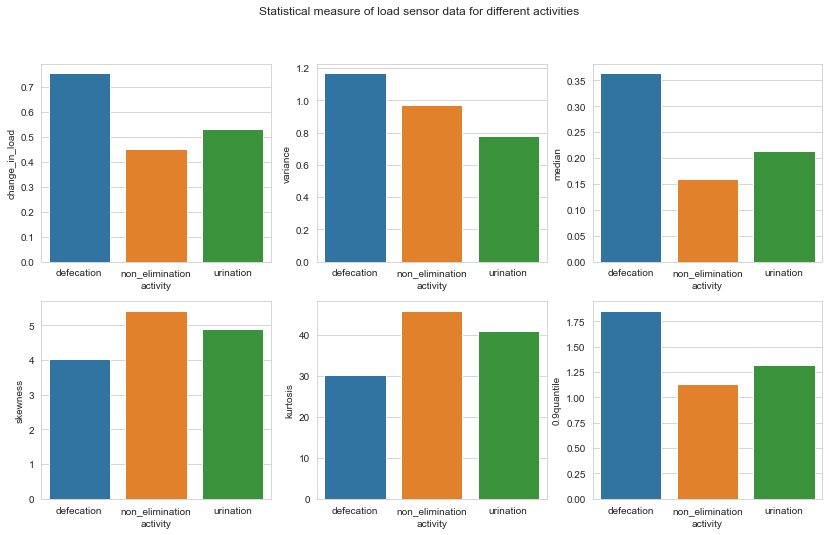

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

fig.suptitle('Statistical measure of load sensor data for different activities')

sns.barplot(ax=axes[0, 0], data=df_sum_stat, x='activity', y='change_in_load')
sns.barplot(ax=axes[0, 1], data=df_sum_stat, x='activity', y='variance')
sns.barplot(ax=axes[0, 2], data=df_sum_stat, x='activity', y='median')
sns.barplot(ax=axes[1, 0], data=df_sum_stat, x='activity', y='skewness')
sns.barplot(ax=axes[1, 1], data=df_sum_stat, x='activity', y='kurtosis')
sns.barplot(ax=axes[1, 2], data=df_sum_stat, x='activity', y='0.9quantile')

### Q. For elimination (defecation and urination) usually the cat digs up the litter, eliminates and covers it up. Does digging up and covering activity differ between urination and defecation? If so, how?

### 1. Hypothesis test to check whether digging and filling process of cat for Urination and Defecation is significantly different or not

In [56]:
df_elimination = df_main[df_main['activity'] != 'non_elimination']
# ~df['Platform'].str.contains('Netflix')
df_elimination.head(3)

,name,activity,weight,duration,start_time,change_in_load,variance,maximum,median,skewness,kurtosis,0.9_quantile,acceleration,jerk,velocity,energy,power,momentum,activity1
0,Ryan,defecation,6933,163.97500,2020-08-06 10:08:05-05:00,1.114670,2.425972,14.11659,0.43164,2.088879,5.125106,3.23730,0.160777,2.623752,18.629980,1422.404601,14.699895,129.161654,elemination
1,Ryan,defecation,6451,204.77494,2020-09-08 04:32:58-05:00,0.996088,2.262248,19.98297,0.32373,2.502551,9.150935,3.06072,0.154408,2.854197,20.030623,1626.238512,15.753942,129.217548,elemination
2,Ryan,defecation,7240,59.97500,2020-07-16 23:03:12-05:00,0.292591,0.218968,4.16925,0.05886,2.892435,11.742110,0.87309,0.040413,0.638543,1.792097,13.463229,0.355113,12.974780,elemination


In [57]:
# Null Hypothesis (H0) : The average loadsensor value is same.
# Alternate Hypothesis (Ha) : The average loadsensor value is different for urination and defecation

#### i. One way ANOVA

In [58]:
aov=pg.anova(dv='change_in_load', between='activity', data=df_elimination, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,activity,84.305317,1,84.305317,1096.894273,1.295364e-226,0.112204
1,Within,667.052298,8679,0.076858,NaN,NaN,NaN


In [59]:
# p-value =~ 0
# Reject Null Hypothesis
# Select Alternate hypothesis

### digging up and covering activity is significantly different between urination and defecation

#### ii. T-test

In [60]:
a=df_elimination[df_elimination['activity']=='urination']['change_in_load']
b=df_elimination[df_elimination['activity']=='defecation']['change_in_load']

In [61]:
ttest_ind(a,b)

(-33.119394207674446, 1.2953644639900604e-226, 8679.0)

In [62]:
# t-stat=-33.82
# p-value ~= 0  
# Reject Null Hypothesis
# Select Alternate hypothesis

### digging up and covering activity is significantly different between urination and defecation

### 2. Multiple images of change in load vs timestamp

In [63]:
def multiple_image():
    activity=input("Enter activity (defecation / urination / non_elimination): ")
    file_no=input("Enter file number (017/048/192): ")
    figure, axis = plt.subplots(3,4, figsize=(18,9.5))
    for n in range (1,13):
        df = pd.read_csv("D:\Ajit\pip\sample_labeled6/VA00000000000"+file_no+"/"+activity+str(n)+".csv")
        x=df.timestamp
        y=df.diff_load_sum

        if n%12==1:
            axis[0,0].plot(x,y)
            axis[0,0].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==2:
            axis[1,0].plot(x,y)
            axis[1,0].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==3:
            axis[2,0].plot(x,y)
            axis[2,0].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==4:
            axis[0,1].plot(x,y)
            axis[0,1].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==5:
            axis[1,1].plot(x,y)
            axis[1,1].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==6:
            axis[2,1].plot(x,y)
            axis[2,1].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==7:
            axis[0,2].plot(x,y)
            axis[0,2].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==8:
            axis[1,2].plot(x,y)
            axis[1,2].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==9:
            axis[2,2].plot(x,y)
            axis[2,2].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==10:
            axis[0,3].plot(x,y)
            axis[0,3].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==11:
            axis[1,3].plot(x,y)
            axis[1,3].set_title(file_no+"_"+activity+"_"+(str(n)))

        elif n%12==0:
            axis[2,3].plot(x,y)
            axis[2,3].set_title(file_no+"_"+activity+"_"+(str(n)))

    # plt.savefig('load_'+file_no+'_'+activity+'1.jpg')

    plt.show()

####  i. Multiple images of Defecaation

Enter activity (defecation / urination / non_elimination): defecation
Enter file number (017/048/192): 037


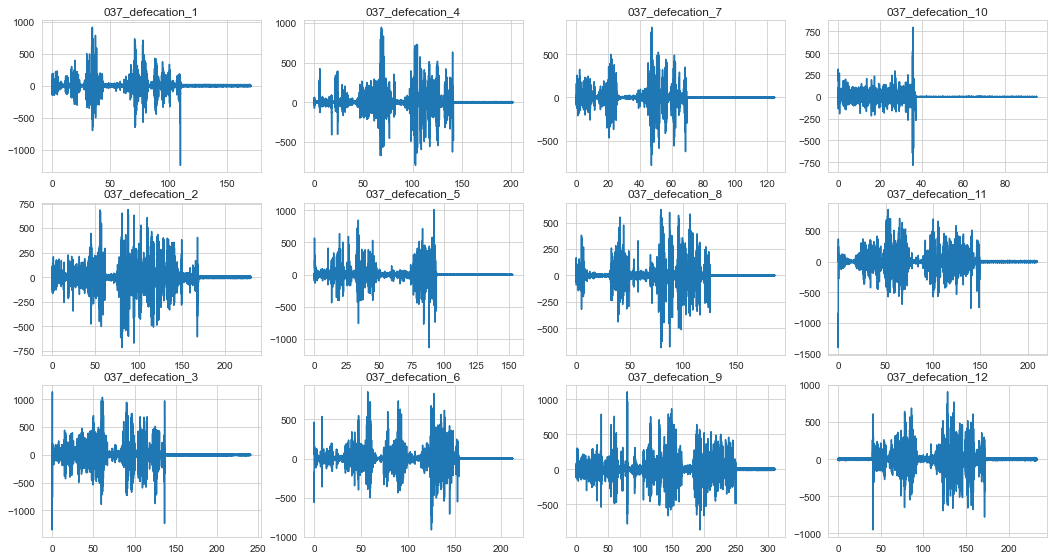

In [71]:
multiple_image()

#### ii. Multiple images of Urination

Enter activity (defecation / urination / non_elimination): urination
Enter file number (017/048/192): 037


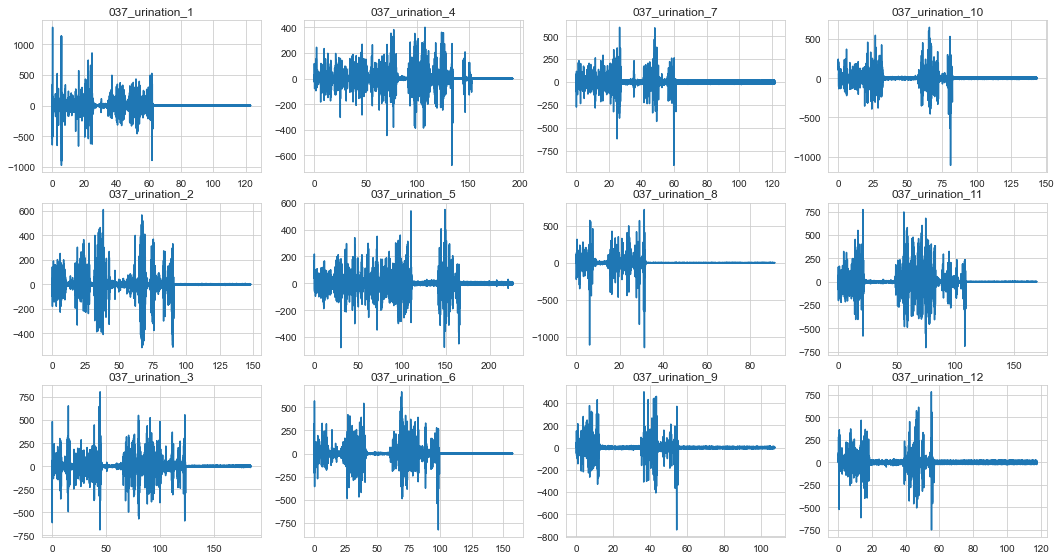

In [72]:
multiple_image()

### Q. Does each cat have a specific behaviour pattern? Are the patterns similar across different cat morphologies?

### 1. Applied Load of different cat with different activities

In [73]:
df_name_activity = pd.DataFrame(df_main.groupby(['name','activity'])['change_in_load'].mean())
df_name_activity.head(6)

change_in_load
name  activity                       
Abby  defecation             0.498415
      non_elimination        0.393147
      urination              0.476755
Azure defecation             0.456924
      non_elimination        0.616895
      urination              0.424277

### 2. Grouping the cats as per their applied load:

In [78]:
df_name = df_main[df_main['name']!='unknown']
df_name = pd.DataFrame(df_name.groupby(['name'])['change_in_load'].mean())

In [79]:
df_name['change_in_load'].min(), df_name['change_in_load'].max()

(0.29212939382733194, 1.2500982031416854)

In [80]:
bins=[0.20,0.40,0.60,0.80,1, 1.25]
df_name['cat_load_type'] = pd.cut(df_name['change_in_load'], bins=bins, labels=['very low', 'low', 'medium', 'moderate', 'high'])
df_name.reset_index()
df_name.head(5)

,change_in_load,cat_load_type
name,,
Abby,0.466878,low
Azure,0.589974,low
Betty Lou,0.469304,low
Bill,0.351562,very low
Boots,0.346088,very low


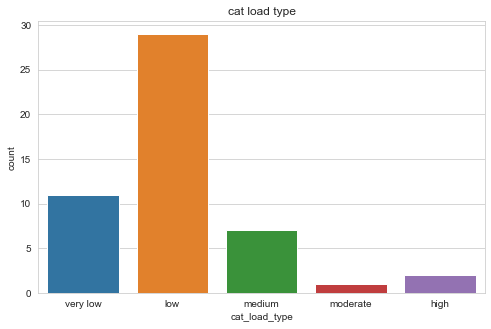

In [81]:
sns.set_style('whitegrid')
plt.figure(figsize = (8, 5))
sns.countplot(x = 'cat_load_type', data = df_name)
plt.title('cat load type')
plt.show()

### Load Catagory
#### 1. Very Low= 0.20-0.40
#### 2. Low = 0.40-0.60
#### 3. Medium= 0.60-0.80
#### 4. Moderate= 0.80-1.00
#### 5. High= 1.00 and above
#### Majority of the cat is applying average differential load between 0.4-0.6 but there are some cat who are applying load more than 1.0 as well

### 3. Hypothesis testing to check all the cat's behavious are significantly different or not:

In [160]:
# Null Hypothesis (H0) : The average loadsensor value is same.
# Alternate Hypothesis (Ha) : The average loadsensor value is different for different cats


# Perform one-way ANOVA analysis as we have 51 cats using one independent variable (mean of sum of differential load).

In [161]:
aov=pg.anova(dv='change_in_load', between='name', data=df_main, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,name,472.940503,51,9.273343,184.647094,0.0,0.42663
1,Within,635.609415,12656,0.050222,NaN,NaN,NaN


In [162]:
# p-value ~= 0  
# Reject Null Hypothesis
# Select Alternate hypothesis

### All the cats behaviour is not simmillier

### Q. Explain why and how the features would help classify the activities? 

### Relationship of all the columns with target variable

In [87]:
df_main.columns

Index(['name', 'activity', 'weight', 'duration', 'start_time',
       'change_in_load', 'variance', 'maximum', 'median', 'skewness',
       'kurtosis', '0.9_quantile', 'acceleration', 'jerk', 'velocity',
       'energy', 'power', 'momentum', 'activity1'],
      dtype='object')

In [88]:
df_stat=pd.DataFrame()

In [89]:
df_stat['Change_in_load']=df_main.groupby(['activity'])['change_in_load'].mean()
df_stat['Variance']=df_main.groupby(['activity'])['variance'].mean()
df_stat['Maximum']=df_main.groupby(['activity'])['maximum'].mean()
df_stat['Median']=df_main.groupby(['activity'])['median'].mean()
df_stat['Skewness']=df_main.groupby(['activity'])['skewness'].mean()
df_stat['Kurtosis']=df_main.groupby(['activity'])['kurtosis'].mean()
df_stat['0.9_quantile']=df_main.groupby(['activity'])['0.9_quantile'].mean()
df_stat['Acceleration']=df_main.groupby(['activity'])['acceleration'].mean()
df_stat['Jerk']=df_main.groupby(['activity'])['jerk'].mean()
df_stat['Velocity']=df_main.groupby(['activity'])['velocity'].mean()
df_stat['Energy']=df_main.groupby(['activity'])['energy'].mean()
df_stat['Power']=df_main.groupby(['activity'])['power'].mean()
df_stat['Momentum']=df_main.groupby(['activity'])['momentum'].mean()

### 1. Table of mean values of all the variables

In [90]:
df_stat=df_stat.transpose()
df_stat

activity,defecation,non_elimination,urination
Change_in_load,0.754053,0.452097,0.529222
Variance,1.167052,0.970231,0.777174
Maximum,14.131420,10.860107,11.460288
Median,0.363323,0.159440,0.213797
Skewness,4.033054,5.425495,4.885582
Kurtosis,30.251160,45.897016,40.867168
0.9_quantile,1.856901,1.132912,1.320612
Acceleration,0.156046,0.095249,0.110365
Jerk,2.686977,1.703194,1.816010
Velocity,14.988661,4.598119,7.675610


### 2. Using Box plot

<AxesSubplot: xlabel='activity', ylabel='momentum'>

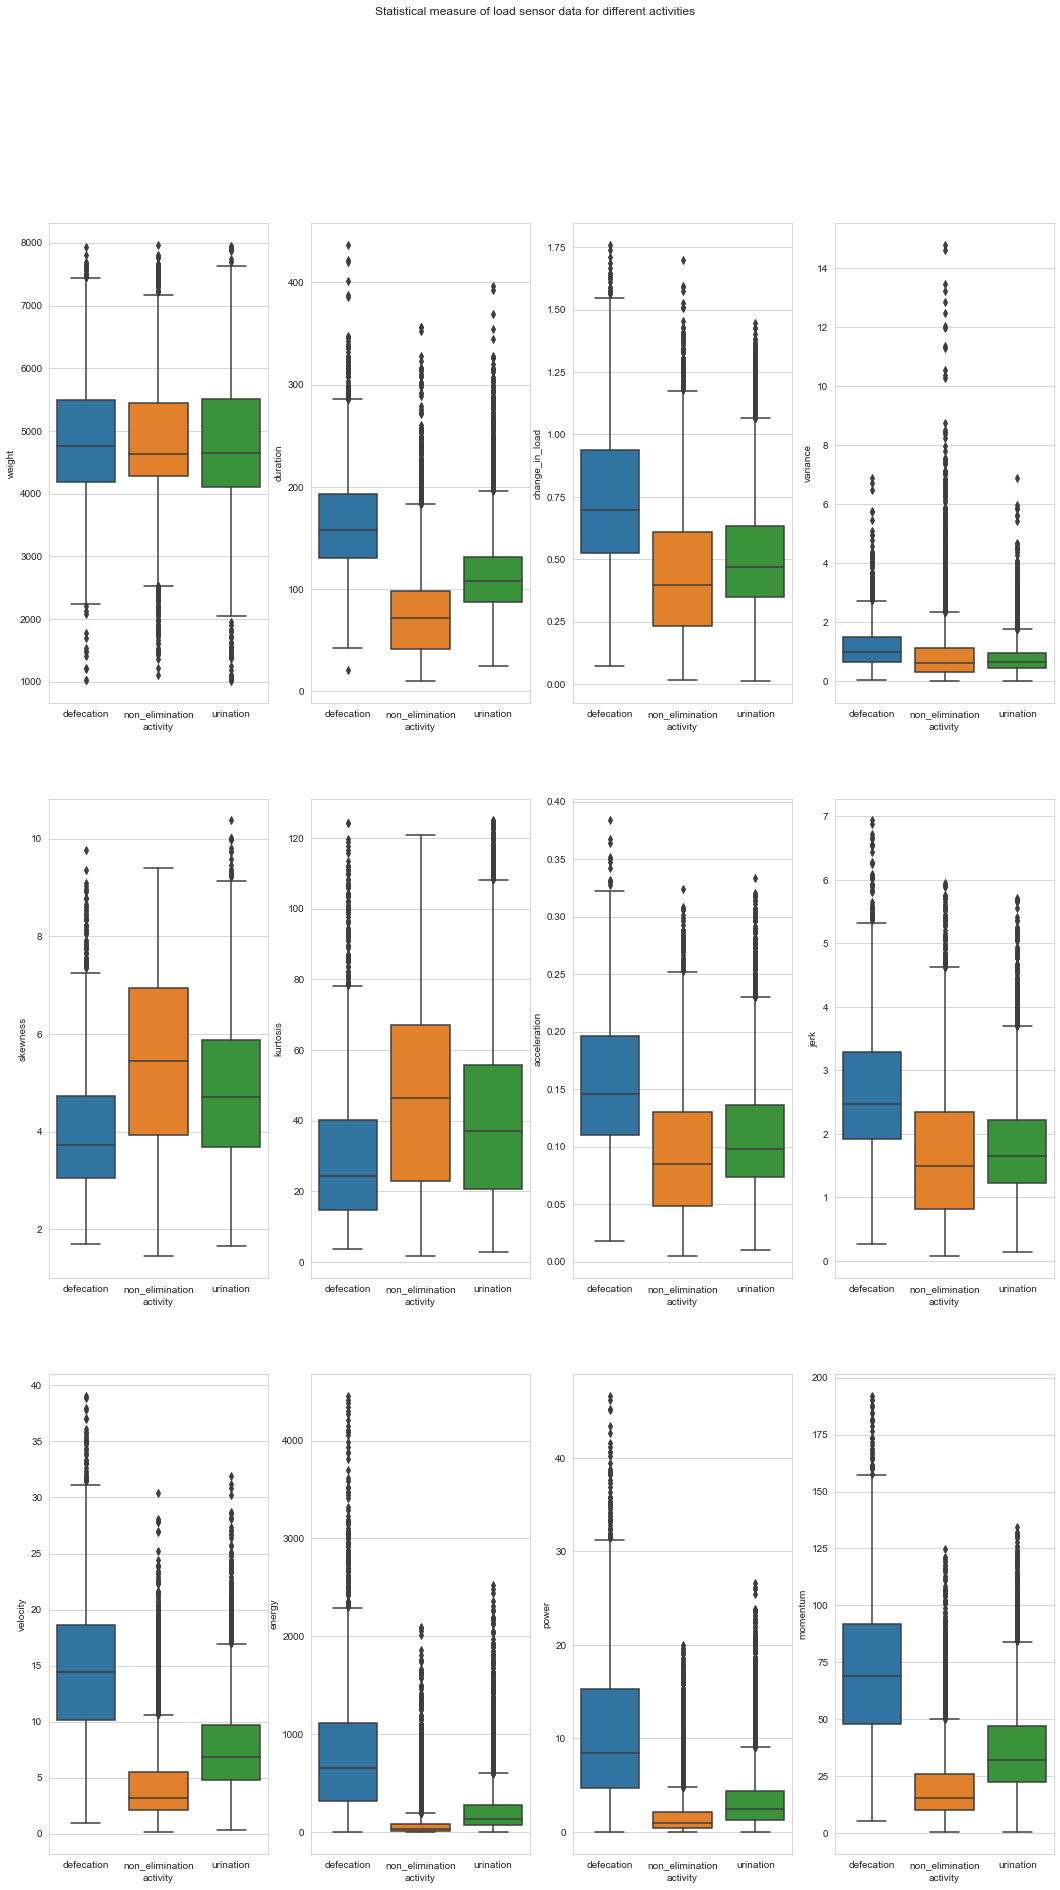

In [91]:
fig, axes = plt.subplots(3, 4, figsize=(18, 30))

fig.suptitle('Statistical measure of load sensor data for different activities')

sns.boxplot(ax=axes[0, 0], data=df_main, x='activity', y='weight')
sns.boxplot(ax=axes[0, 1], data=df_main, x='activity', y='duration')
sns.boxplot(ax=axes[0, 2], data=df_main, x='activity', y='change_in_load')
sns.boxplot(ax=axes[0, 3], data=df_main, x='activity', y='variance')
sns.boxplot(ax=axes[1, 0], data=df_main, x='activity', y='skewness')
sns.boxplot(ax=axes[1, 1], data=df_main, x='activity', y='kurtosis')
sns.boxplot(ax=axes[1, 2], data=df_main, x='activity', y='acceleration')
sns.boxplot(ax=axes[1, 3], data=df_main, x='activity', y='jerk')
sns.boxplot(ax=axes[2, 0], data=df_main, x='activity', y='velocity')
sns.boxplot(ax=axes[2, 1], data=df_main, x='activity', y='energy')
sns.boxplot(ax=axes[2, 2], data=df_main, x='activity', y='power')
sns.boxplot(ax=axes[2, 3], data=df_main, x='activity', y='momentum')

### Correlation

In [82]:
df_corr=df_main.drop(['name', 'activity', 'start_time'],axis=1)

<AxesSubplot: >

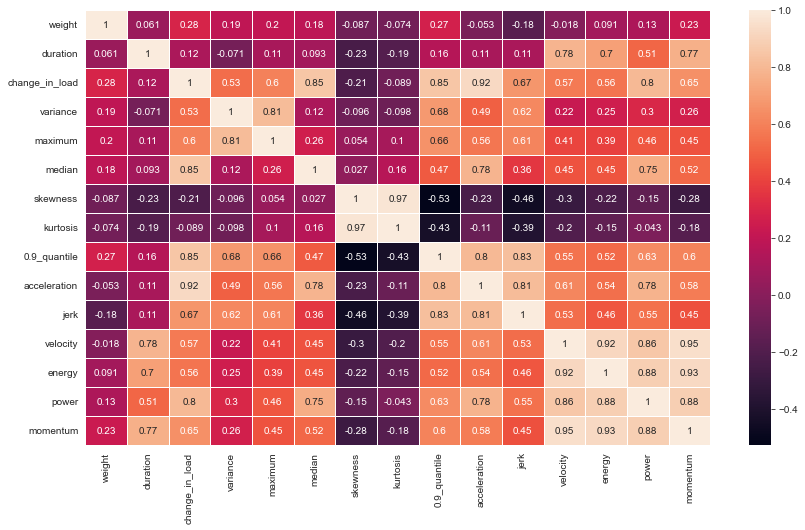

In [85]:
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(df_corr.corr(), annot=True, linewidths=.5, ax=ax)

In [173]:
# Change in load ~ acceleration = 0.92
# Change in load ~ 0.9_quantile = 0.85
# Acceleration ~ differential load = 0.92
# skewness ~ kurtosis = 0.97
# velocity ~ energy = 0.92
# velocity ~ power = 0.86
# velocity ~ momentum = 0.95